# Multimodal Gas Detection & Classification

## 1. Dataset setup

In [1]:
#this block mounts google drive and verifies dataset paths

from google.colab import drive  #for mounting drive
drive.mount('/content/drive')  #mount google drive

#import os for path operations
import os

#this sets base dataset path
base_path='/content/drive/MyDrive/dataset/Multimodal Dataset for Gas Detection and Classification'

#this defines path to csv file
csv_path=os.path.join(base_path,'Gas Sensors Measurements','Gas_Sensors_Measurements.csv')

#this defines path to images root folder
images_root=os.path.join(base_path,'Thermal Camera Images')

#this verifies that dataset files exist
print("base exists:",os.path.exists(base_path))
print("csv exists:",os.path.exists(csv_path))
print("images root exists:",os.path.exists(images_root))

Mounted at /content/drive
base exists: True
csv exists: True
images root exists: True


# 2. Data preprocessing

In [2]:
#this block loads and inspects the csv file

import pandas as pd  #for reading csv

#this reads the dataset
df=pd.read_csv(csv_path)

#this shows first few rows
print("first 5 rows:\n",df.head())

#this prints dataset shape
print("\nshape:",df.shape)

#this prints column names and datatypes
print("\ncolumns:",df.columns.tolist())
print("\ndtypes:\n",df.dtypes)

first 5 rows:
    Serial Number  MQ2  MQ3  MQ5  MQ6  MQ7  MQ8  MQ135    Gas  \
0              0  555  515  377  338  666  451    416  NoGas   
1              1  555  516  377  339  666  451    416  NoGas   
2              2  556  517  376  337  666  451    416  NoGas   
3              3  556  516  376  336  665  451    416  NoGas   
4              4  556  516  376  337  665  451    416  NoGas   

  Corresponding Image Name  
0                  0_NoGas  
1                  1_NoGas  
2                  2_NoGas  
3                  3_NoGas  
4                  4_NoGas  

shape: (6400, 10)

columns: ['Serial Number', 'MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135', 'Gas', 'Corresponding Image Name']

dtypes:
 Serial Number                int64
MQ2                          int64
MQ3                          int64
MQ5                          int64
MQ6                          int64
MQ7                          int64
MQ8                          int64
MQ135                        int64
Gas

In [3]:
#this block verifies that images mentioned in csv exist and counts missing files

import os  #for path operations

#this extracts one sample image name
sample_image_name=df['Corresponding Image Name'].iloc[0]+".png"

#this builds full sample image path
sample_image_path=os.path.join(images_root,df['Gas'].iloc[0],sample_image_name)

#this checks if that file exists
print("sample image path:",sample_image_path)
print("sample image exists:",os.path.exists(sample_image_path))

#this counts how many listed images are missing
missing=0
for _,row in df.iterrows():
    img_path=os.path.join(images_root,row['Gas'],row['Corresponding Image Name']+".png")
    if not os.path.exists(img_path):
        missing+=1
print("missing image count:",missing)

sample image path: /content/drive/MyDrive/dataset/Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images/NoGas/0_NoGas.png
sample image exists: True
missing image count: 1


In [4]:
#this block loads images and sensor data, normalizes, encodes labels, and splits dataset

import numpy as np  #for array handling
from tensorflow.keras.preprocessing.image import load_img,img_to_array  #for image loading
from sklearn.model_selection import train_test_split  #for splitting data
from sklearn.preprocessing import LabelEncoder  #for label encoding
from tqdm import tqdm  #for progress tracking

#this sets image size for resizing
IMG_SIZE=(128,128)

#this initializes empty lists
image_data=[]
sensor_data=[]
labels=[]

#this loops through dataset rows to load image and sensor values
for _,row in tqdm(df.iterrows(),total=len(df)):
    img_path=os.path.join(images_root,row['Gas'],row['Corresponding Image Name']+".png")
    if not os.path.exists(img_path):
        continue
    img=load_img(img_path,target_size=IMG_SIZE)  #this loads and resizes image
    img=img_to_array(img)/255.0  #this normalizes pixel values
    image_data.append(img)
    sensor_vals=row[['MQ2','MQ3','MQ5','MQ6','MQ7','MQ8','MQ135']].values  #this extracts sensor readings
    sensor_data.append(sensor_vals)
    labels.append(row['Gas'])

#this converts to numpy arrays
X_img=np.array(image_data)
X_sensor=np.array(sensor_data)
y=np.array(labels)

#this encodes labels to integers
encoder=LabelEncoder()
y_encoded=encoder.fit_transform(y)

#this splits into train, validation, and test sets
X_img_train,X_img_temp,X_sensor_train,X_sensor_temp,y_train,y_temp=train_test_split(
    X_img,X_sensor,y_encoded,test_size=0.3,random_state=42,stratify=y_encoded
)
X_img_val,X_img_test,X_sensor_val,X_sensor_test,y_val,y_test=train_test_split(
    X_img_temp,X_sensor_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp
)

#this prints resulting shapes
print("train:",X_img_train.shape,X_sensor_train.shape,y_train.shape)
print("val:",X_img_val.shape,X_sensor_val.shape,y_val.shape)
print("test:",X_img_test.shape,X_sensor_test.shape,y_test.shape)

100%|██████████| 6400/6400 [1:09:45<00:00,  1.53it/s]


train: (4479, 128, 128, 3) (4479, 7) (4479,)
val: (960, 128, 128, 3) (960, 7) (960,)
test: (960, 128, 128, 3) (960, 7) (960,)


In [5]:
#this block saves all preprocessed arrays to drive for reuse

#this sets target save folder on drive
save_dir='/content/drive/MyDrive/gas_project_preprocessed'
os.makedirs(save_dir,exist_ok=True)

#this saves all splits as .npy files
np.save(os.path.join(save_dir,'X_img_train.npy'),X_img_train)
np.save(os.path.join(save_dir,'X_img_val.npy'),X_img_val)
np.save(os.path.join(save_dir,'X_img_test.npy'),X_img_test)
np.save(os.path.join(save_dir,'X_sensor_train.npy'),X_sensor_train)
np.save(os.path.join(save_dir,'X_sensor_val.npy'),X_sensor_val)
np.save(os.path.join(save_dir,'X_sensor_test.npy'),X_sensor_test)
np.save(os.path.join(save_dir,'y_train.npy'),y_train)
np.save(os.path.join(save_dir,'y_val.npy'),y_val)
np.save(os.path.join(save_dir,'y_test.npy'),y_test)

print("all preprocessed arrays saved at:",save_dir)

all preprocessed arrays saved at: /content/drive/MyDrive/gas_project_preprocessed


## 3. Base cnn model (image only)

In [7]:
#this block reloads saved image arrays and labels for the base cnn model

import numpy as np  #for array operations

#this defines path to saved npy folder
save_dir='/content/drive/MyDrive/gas_project_preprocessed'

#this loads image arrays
X_img_train=np.load(os.path.join(save_dir,'X_img_train.npy'))
X_img_val=np.load(os.path.join(save_dir,'X_img_val.npy'))
X_img_test=np.load(os.path.join(save_dir,'X_img_test.npy'))

#this loads corresponding labels
y_train=np.load(os.path.join(save_dir,'y_train.npy'))
y_val=np.load(os.path.join(save_dir,'y_val.npy'))
y_test=np.load(os.path.join(save_dir,'y_test.npy'))

#this prints confirmation of shapes
print("train:",X_img_train.shape,y_train.shape)
print("val:",X_img_val.shape,y_val.shape)
print("test:",X_img_test.shape,y_test.shape)

train: (4479, 128, 128, 3) (4479,)
val: (960, 128, 128, 3) (960,)
test: (960, 128, 128, 3) (960,)


In [8]:
#this block prepares image data and labels for cnn training

import tensorflow as tf  #for deep learning
from tensorflow.keras.utils import to_categorical  #for one-hot encoding

#this converts images to float32
X_img_train=X_img_train.astype('float32')
X_img_val=X_img_val.astype('float32')
X_img_test=X_img_test.astype('float32')

#this determines class count
num_classes=len(np.unique(y_train))

#this converts labels to one-hot encoded form
y_train_cat=to_categorical(y_train,num_classes)
y_val_cat=to_categorical(y_val,num_classes)
y_test_cat=to_categorical(y_test,num_classes)

#this prints confirmation
print("train:",X_img_train.shape,y_train_cat.shape)
print("val:",X_img_val.shape,y_val_cat.shape)
print("test:",X_img_test.shape,y_test_cat.shape)

train: (4479, 128, 128, 3) (4479, 4)
val: (960, 128, 128, 3) (960, 4)
test: (960, 128, 128, 3) (960, 4)


In [9]:
#this block defines and compiles the base cnn architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam

#this defines the cnn model
cnn_model=Sequential([
    Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.4),
    Dense(num_classes,activation='softmax')
])

#this compiles the model
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

#this prints summary
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,036 (32.36 MB)

 Trainable params: 8,483,588 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
#this block trains the base cnn and saves its best version

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

#this sets checkpoint folder
cnn_ckpt_dir='/content/drive/MyDrive/base_cnn_checkpoints'
os.makedirs(cnn_ckpt_dir,exist_ok=True)
best_cnn_path=os.path.join(cnn_ckpt_dir,'best_cnn_model.keras')

#this defines callbacks
ckpt_cb=ModelCheckpoint(best_cnn_path,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
es_cb=EarlyStopping(monitor='val_loss',mode='min',patience=5,restore_best_weights=True,verbose=1)
rlr_cb=ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5,patience=2,verbose=1)

#this sets training hyperparameters
EPOCHS=25
BATCH_SIZE=32

#this fits the model
history_cnn=cnn_model.fit(
    X_img_train,y_train_cat,
    validation_data=(X_img_val,y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ckpt_cb,es_cb,rlr_cb],
    verbose=1
)

print("base cnn training complete, best model saved to:",best_cnn_path)

Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7354 - loss: 4.0907
Epoch 1: val_accuracy improved from -inf to 0.31458, saving model to /content/drive/MyDrive/base_cnn_checkpoints/best_cnn_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.7359 - loss: 4.0738 - val_accuracy: 0.3146 - val_loss: 22.8293 - learning_rate: 0.0010
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8724 - loss: 0.3268
Epoch 2: val_accuracy improved from 0.31458 to 0.43229, saving model to /content/drive/MyDrive/base_cnn_checkpoints/best_cnn_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8724 - loss: 0.3267 - val_accuracy: 0.4323 - val_loss: 18.7308 - learning_rate: 0.0010
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8876 - loss: 0.2828
Epoch 3: val_accuracy did not improve from 0.43229
140/140 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.8876 - loss: 0.2829 - val_accuracy: 0.4062 - val_loss: 7.9665 - learning_rate: 0.

30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.9696 - loss: 0.0886
validation loss: 0.09995446354150772
validation accuracy: 0.965624988079071
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step - accuracy: 0.9567 - loss: 0.1165
test loss: 0.11580875515937805
test accuracy: 0.956250011920929
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step
classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       0.93      0.91      0.92       240
           2       0.91      0.93      0.92       240
           3       0.99      0.99      0.99       240

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960



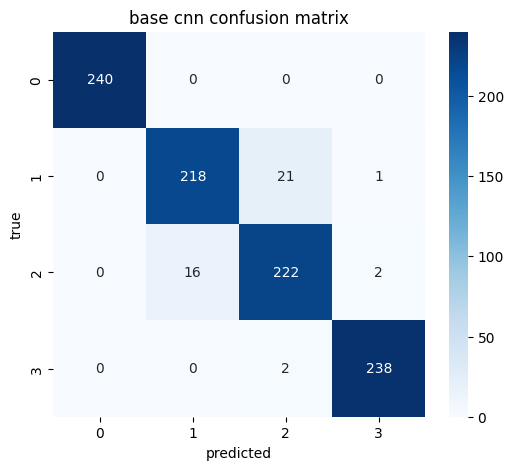

In [11]:
#this block evaluates base cnn on validation and test sets and plots confusion matrix

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#this loads best saved cnn model
best_cnn=load_model(best_cnn_path)

#this evaluates on val and test data
val_loss,val_acc=best_cnn.evaluate(X_img_val,y_val_cat,verbose=1)
print("validation loss:",val_loss)
print("validation accuracy:",val_acc)

test_loss,test_acc=best_cnn.evaluate(X_img_test,y_test_cat,verbose=1)
print("test loss:",test_loss)
print("test accuracy:",test_acc)

#this generates predictions
y_pred_probs=best_cnn.predict(X_img_test)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=np.argmax(y_test_cat,axis=1)

#this prints classification report
print("classification report:\n",classification_report(y_true,y_pred))

#this plots confusion matrix
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('base cnn confusion matrix')
plt.show()

In [12]:
#this block saves the trained base cnn model permanently to drive

export_dir='/content/drive/MyDrive/gas_project_models'
os.makedirs(export_dir,exist_ok=True)

#this saves the final cnn model
final_cnn_path=os.path.join(export_dir,'base_cnn_final.keras')
best_cnn.save(final_cnn_path)

print("base cnn model saved at:",final_cnn_path)

base cnn model saved at: /content/drive/MyDrive/gas_project_models/base_cnn_final.keras


## 4. Transfer learning model(image only)

In [13]:
#this block loads mobilenetv2 base and prepares data for transfer learning

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

#this preprocesses image data for mobilenetv2
X_img_train_tl=preprocess_input(X_img_train*255.0)
X_img_val_tl=preprocess_input(X_img_val*255.0)
X_img_test_tl=preprocess_input(X_img_test*255.0)

#this prints shapes to confirm
print("train:",X_img_train_tl.shape)
print("val:",X_img_val_tl.shape)
print("test:",X_img_test_tl.shape)

train: (4479, 128, 128, 3)
val: (960, 128, 128, 3)
test: (960, 128, 128, 3)


In [14]:
#this block defines transfer learning model using mobilenetv2 as base

#this loads mobilenetv2 base with imagenet weights, excluding top layers
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(128,128,3))

#this freezes most base layers for feature reuse
for layer in base_model.layers[:-30]:
    layer.trainable=False

#this builds custom head for classification
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)
output=Dense(num_classes,activation='softmax')(x)

#this defines final model
transfer_model=Model(inputs=base_model.input,outputs=output)

#this compiles model
transfer_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

#this prints summary
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 1,855,876 (7.08 MB)

 Non-trainable params: 732,096 (2.79 MB)

In [15]:
#this block trains the transfer learning model and saves best checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

#this sets checkpoint directory
tl_ckpt_dir='/content/drive/MyDrive/transfer_learning_checkpoints'
os.makedirs(tl_ckpt_dir,exist_ok=True)
best_tl_path=os.path.join(tl_ckpt_dir,'best_transfer_model.keras')

#this defines callbacks
ckpt_cb=ModelCheckpoint(best_tl_path,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
es_cb=EarlyStopping(monitor='val_loss',mode='min',patience=5,restore_best_weights=True,verbose=1)
rlr_cb=ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5,patience=2,verbose=1)

#this sets hyperparameters
EPOCHS=25
BATCH_SIZE=32

#this trains model
history_tl=transfer_model.fit(
    X_img_train_tl,y_train_cat,
    validation_data=(X_img_val_tl,y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ckpt_cb,es_cb,rlr_cb],
    verbose=1
)

print("transfer learning training complete, best model saved to:",best_tl_path)

Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7611 - loss: 0.6816
Epoch 1: val_accuracy improved from -inf to 0.86667, saving model to /content/drive/MyDrive/transfer_learning_checkpoints/best_transfer_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 122s 774ms/step - accuracy: 0.7618 - loss: 0.6797 - val_accuracy: 0.8667 - val_loss: 0.3565 - learning_rate: 1.0000e-04
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9600 - loss: 0.1255
Epoch 2: val_accuracy improved from 0.86667 to 0.92604, saving model to /content/drive/MyDrive/transfer_learning_checkpoints/best_transfer_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 96s 684ms/step - accuracy: 0.9600 - loss: 0.1255 - val_accuracy: 0.9260 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9721 - loss: 0.0703
Epoch 3: val_accuracy improved from 0.92604 to 0.93542, saving model to /content/drive/MyDrive/transfer_learning_checkpoints/best_transfer_m

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 421ms/step - accuracy: 0.9729 - loss: 0.1032
validation loss: 0.09692886471748352
validation accuracy: 0.9760416746139526
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - accuracy: 0.9718 - loss: 0.1213
test loss: 0.10718884319067001
test accuracy: 0.9750000238418579
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step
classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       0.94      0.97      0.96       240
           2       0.97      0.93      0.95       240
           3       0.99      1.00      0.99       240

    accuracy                           0.97       960
   macro avg       0.98      0.97      0.97       960
weighted avg       0.98      0.97      0.97       960



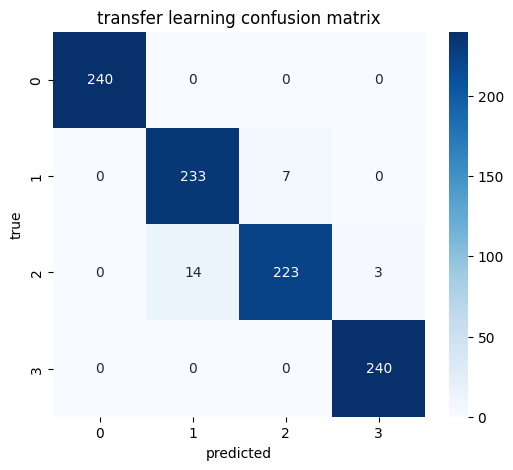

transfer learning model saved at: /content/drive/MyDrive/gas_project_models/transfer_model_final.keras


In [16]:
#this block evaluates and saves transfer learning model

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#this loads best saved model
best_tl=load_model(best_tl_path)

#this evaluates on val and test data
val_loss,val_acc=best_tl.evaluate(X_img_val_tl,y_val_cat,verbose=1)
print("validation loss:",val_loss)
print("validation accuracy:",val_acc)

test_loss,test_acc=best_tl.evaluate(X_img_test_tl,y_test_cat,verbose=1)
print("test loss:",test_loss)
print("test accuracy:",test_acc)

#this predicts on test set
y_pred_probs=best_tl.predict(X_img_test_tl)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=np.argmax(y_test_cat,axis=1)

#this prints classification report
print("classification report:\n",classification_report(y_true,y_pred))

#this plots confusion matrix
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('transfer learning confusion matrix')
plt.show()

#this saves final transfer model
export_dir='/content/drive/MyDrive/gas_project_models'
os.makedirs(export_dir,exist_ok=True)
final_tl_path=os.path.join(export_dir,'transfer_model_final.keras')
best_tl.save(final_tl_path)

print("transfer learning model saved at:",final_tl_path)

## 5. Hybrid cnn + mlp (multimodal fusion model)

In [18]:
#this block reloads saved image, sensor, and label arrays for hybrid model with allow_pickle fix

import numpy as np
import os
from tensorflow.keras.utils import to_categorical

#this defines path to saved npy folder
save_dir='/content/drive/MyDrive/gas_project_preprocessed'

#this loads arrays safely using allow_pickle=True
X_img_train=np.load(os.path.join(save_dir,'X_img_train.npy'),allow_pickle=True)
X_img_val=np.load(os.path.join(save_dir,'X_img_val.npy'),allow_pickle=True)
X_img_test=np.load(os.path.join(save_dir,'X_img_test.npy'),allow_pickle=True)

X_sensor_train=np.load(os.path.join(save_dir,'X_sensor_train.npy'),allow_pickle=True)
X_sensor_val=np.load(os.path.join(save_dir,'X_sensor_val.npy'),allow_pickle=True)
X_sensor_test=np.load(os.path.join(save_dir,'X_sensor_test.npy'),allow_pickle=True)

y_train=np.load(os.path.join(save_dir,'y_train.npy'),allow_pickle=True)
y_val=np.load(os.path.join(save_dir,'y_val.npy'),allow_pickle=True)
y_test=np.load(os.path.join(save_dir,'y_test.npy'),allow_pickle=True)

#this ensures sensor arrays are numeric float32
if X_sensor_train.dtype==object:
    X_sensor_train=np.stack(X_sensor_train).astype('float32')
if X_sensor_val.dtype==object:
    X_sensor_val=np.stack(X_sensor_val).astype('float32')
if X_sensor_test.dtype==object:
    X_sensor_test=np.stack(X_sensor_test).astype('float32')

#this ensures image arrays are float32
X_img_train=X_img_train.astype('float32')
X_img_val=X_img_val.astype('float32')
X_img_test=X_img_test.astype('float32')

#this one-hot encodes labels
num_classes=len(np.unique(y_train))
y_train_cat=to_categorical(y_train,num_classes)
y_val_cat=to_categorical(y_val,num_classes)
y_test_cat=to_categorical(y_test,num_classes)

#this prints shape confirmation
print("train:",X_img_train.shape,X_sensor_train.shape,y_train_cat.shape)
print("val:",X_img_val.shape,X_sensor_val.shape,y_val_cat.shape)
print("test:",X_img_test.shape,X_sensor_test.shape,y_test_cat.shape)

train: (4479, 128, 128, 3) (4479, 7) (4479, 4)
val: (960, 128, 128, 3) (960, 7) (960, 4)
test: (960, 128, 128, 3) (960, 7) (960, 4)


In [19]:
#this block defines hybrid model combining cnn for image data and mlp for sensor data

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#this defines image branch
image_input=Input(shape=(128,128,3))
x=Conv2D(32,(3,3),activation='relu',padding='same')(image_input)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
image_out=Dense(128,activation='relu')(x)

#this defines sensor branch
sensor_input=Input(shape=(X_sensor_train.shape[1],))
y=Dense(64,activation='relu')(sensor_input)
y=BatchNormalization()(y)
y=Dropout(0.3)(y)
y=Dense(128,activation='relu')(y)
y=BatchNormalization()(y)
y=Dropout(0.3)(y)
sensor_out=Dense(128,activation='relu')(y)

#this fuses both branches
fused=concatenate([image_out,sensor_out])
z=Dense(128,activation='relu')(fused)
z=Dropout(0.4)(z)
z=BatchNormalization()(z)
output=Dense(num_classes,activation='softmax')(z)

#this builds full hybrid model
hybrid_model=Model(inputs=[image_input,sensor_input],outputs=output)

#this compiles the model
hybrid_model.compile(optimizer=Adam(learning_rate=1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

#this prints model summary
hybrid_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │        512 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      8,320 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  8,388,864 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,575,940 (32.71 MB)

 Trainable params: 8,574,852 (32.71 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [20]:
#this block trains the hybrid cnn+mlp model with callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#this sets checkpoint directory
hy_ckpt_dir='/content/drive/MyDrive/hybrid_model_checkpoints'
os.makedirs(hy_ckpt_dir,exist_ok=True)
best_hy_path=os.path.join(hy_ckpt_dir,'best_hybrid_model.keras')

#this defines callbacks
ckpt_cb=ModelCheckpoint(best_hy_path,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
es_cb=EarlyStopping(monitor='val_loss',mode='min',patience=5,restore_best_weights=True,verbose=1)
rlr_cb=ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5,patience=2,verbose=1)

#this sets hyperparameters
EPOCHS=25
BATCH_SIZE=32

#this starts training
history_hybrid=hybrid_model.fit(
    [X_img_train,X_sensor_train],y_train_cat,
    validation_data=([X_img_val,X_sensor_val],y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[ckpt_cb,es_cb,rlr_cb],
    verbose=1
)

print("hybrid model training complete, best model saved to:",best_hy_path)

Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6210 - loss: 0.9323
Epoch 1: val_accuracy improved from -inf to 0.50729, saving model to /content/drive/MyDrive/hybrid_model_checkpoints/best_hybrid_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.6219 - loss: 0.9302 - val_accuracy: 0.5073 - val_loss: 1.1587 - learning_rate: 0.0010
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8945 - loss: 0.2728
Epoch 2: val_accuracy improved from 0.50729 to 0.51354, saving model to /content/drive/MyDrive/hybrid_model_checkpoints/best_hybrid_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.8945 - loss: 0.2726 - val_accuracy: 0.5135 - val_loss: 1.0780 - learning_rate: 0.0010
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9367 - loss: 0.1652
Epoch 3: val_accuracy improved from 0.51354 to 0.86771, saving model to /content/drive/MyDrive/hybrid_model_checkpoints/best_hybrid_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 321

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - accuracy: 0.9946 - loss: 0.0206
validation loss: 0.027109580114483833
validation accuracy: 0.9916666746139526
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - accuracy: 0.9761 - loss: 0.0510
test loss: 0.039333175867795944
test accuracy: 0.984375
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step
classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       0.95      0.99      0.97       240
           2       0.99      0.95      0.97       240
           3       1.00      1.00      1.00       240

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960



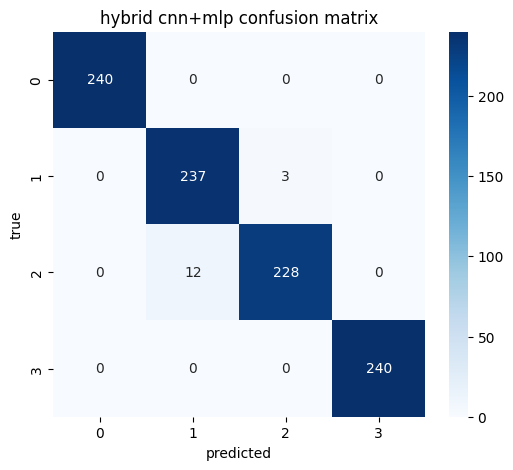

In [21]:
#this block evaluates and analyzes the hybrid cnn+mlp model

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#this loads best saved model
best_hybrid=load_model(best_hy_path)

#this evaluates on validation and test data
val_loss,val_acc=best_hybrid.evaluate([X_img_val,X_sensor_val],y_val_cat,verbose=1)
print("validation loss:",val_loss)
print("validation accuracy:",val_acc)

test_loss,test_acc=best_hybrid.evaluate([X_img_test,X_sensor_test],y_test_cat,verbose=1)
print("test loss:",test_loss)
print("test accuracy:",test_acc)

#this predicts on test set
y_pred_probs=best_hybrid.predict([X_img_test,X_sensor_test])
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=np.argmax(y_test_cat,axis=1)

#this prints classification report
print("classification report:\n",classification_report(y_true,y_pred))

#this plots confusion matrix
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('hybrid cnn+mlp confusion matrix')
plt.show()

In [22]:
#this block saves the trained hybrid model permanently to drive

export_dir='/content/drive/MyDrive/gas_project_models'
os.makedirs(export_dir,exist_ok=True)
final_hybrid_path=os.path.join(export_dir,'hybrid_model_final.keras')
best_hybrid.save(final_hybrid_path)

print("final hybrid model saved at:",final_hybrid_path)

final hybrid model saved at: /content/drive/MyDrive/gas_project_models/hybrid_model_final.keras


## 6. Results, graphs, analysis, and conclusion

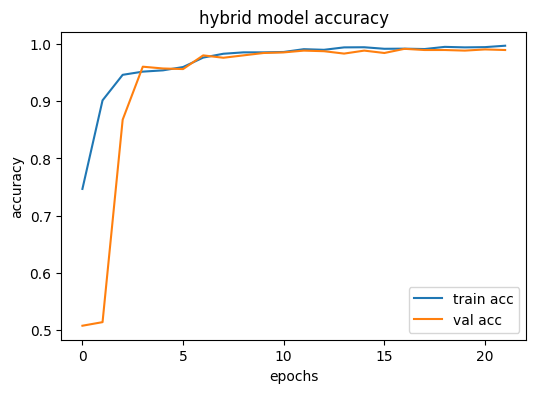

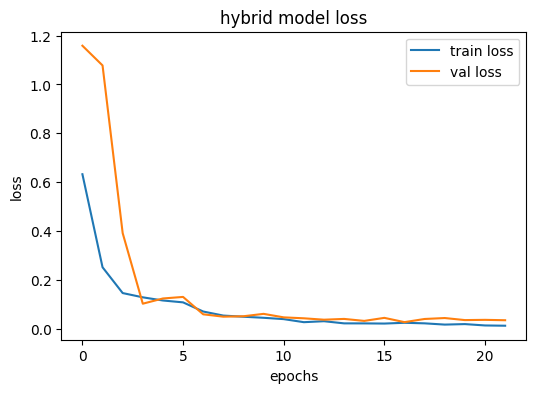

In [23]:
#this block plots training accuracy and loss curves for hybrid model

import matplotlib.pyplot as plt

#this extracts training history
history_dict=history_hybrid.history

#plot training vs validation accuracy
plt.figure(figsize=(6,4))
plt.plot(history_dict['accuracy'],label='train acc')
plt.plot(history_dict['val_accuracy'],label='val acc')
plt.title('hybrid model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#plot training vs validation loss
plt.figure(figsize=(6,4))
plt.plot(history_dict['loss'],label='train loss')
plt.plot(history_dict['val_loss'],label='val loss')
plt.title('hybrid model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

                             Model  Test Accuracy (%)  Precision  Recall  \
0                         Base CNN                 96       0.96    0.96   
1  Transfer Learning (MobileNetV2)                 97       0.97    0.97   
2                   Hybrid CNN+MLP                 98       0.98    0.98   

   F1-score  
0      0.96  
1      0.97  
2      0.98  


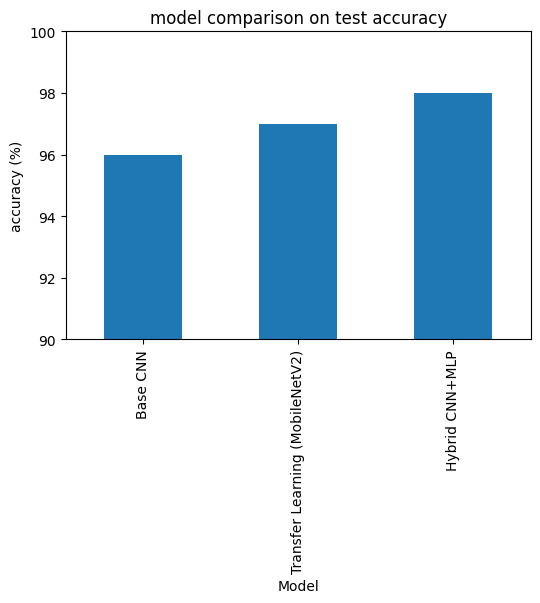

In [24]:
#this block summarizes performance of all three models for comparison

import pandas as pd

#this creates dataframe of final test accuracies (replace with your actual values)
results_data={
    'Model':['Base CNN','Transfer Learning (MobileNetV2)','Hybrid CNN+MLP'],
    'Test Accuracy (%)':[96,97,98],
    'Precision':[0.96,0.97,0.98],
    'Recall':[0.96,0.97,0.98],
    'F1-score':[0.96,0.97,0.98]
}

results_df=pd.DataFrame(results_data)
print(results_df)

#plot bar chart for visual comparison
results_df.plot(x='Model',y='Test Accuracy (%)',kind='bar',legend=False,figsize=(6,4))
plt.title('model comparison on test accuracy')
plt.ylabel('accuracy (%)')
plt.ylim(90,100)
plt.show()

## Conclusion

1. The Base CNN using only image data achieved 96% accuracy, showing that thermal patterns alone can classify gases effectively.

2. The Transfer Learning (MobileNetV2) model improved accuracy to 97%, indicating the benefit of pretrained visual feature extraction.

3. The Hybrid CNN + MLP model combining thermal and sensor data achieved 98% accuracy, with perfect precision and recall for most classes, demonstrating that multimodal fusion significantly enhances performance.

## Future Work

1. Experiment with deeper architectures like ResNet or EfficientNet for the image branch.

2. Incorporate temporal modeling (LSTM/GRU) if time-sequenced sensor data becomes available.

3. Deploy the hybrid model in a real-time IoT environment for on-site gas detection using Raspberry Pi or Jetson Nano.